<a href="https://colab.research.google.com/github/MarcosVeniciu/Rede-Neural-Siamesa/blob/main/Arquitetura_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Referencias principais
## Artigo: https://arxiv.org/pdf/1503.03832.pdf
## Código Keras (melhor): https://www.tensorflow.org/addons/tutorials/losses_triplet?hl=pt-br#semihard_online_learning
## Código: https://medium.com/@crimy/one-shot-learning-siamese-networks-and-triplet-loss-with-keras-2885ed022352
## Gerar Triplets: https://omoindrot.github.io/triplet-loss
#
# Referências
## Função de TripletHardLoss: https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletHardLoss
## Função de TripletSemiHardLoss: https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletSemiHardLoss
## Triple loss keras:  https://keras.io/examples/vision/siamese_network/ 

In [ ]:
!pip install -q -U tensorflow-addons

import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import random
import shutil
import cv2
import os

size = 96
input_shape = (1, size, size)
tf.keras.backend.set_image_data_format('channels_first')

# Dataset

In [ ]:
def preprocess_image(dataset):
  resized = []
  for image in dataset:
    img_resized = cv2.resize(image, (size, size))
    img_resized = tf.cast(img_resized, tf.float32)/ 255
    resized.append(img_resized)
  return np.array(resized)

In [ ]:
(x_train_origin, y_train_origin), _ = keras.datasets.mnist.load_data()
x_train_origin = preprocess_image(x_train_origin)

x_train_origin = x_train_origin.reshape(x_train_origin.shape[0], 1, size, size)

train_ds = x_train_origin
train_label = y_train_origin

# Modelo

## Inception

In [ ]:
#### PART OF THIS CODE IS USING CODE FROM VICTOR SY WANG: https://github.com/iwantooxxoox/Keras-OpenFace/blob/master/utils.py ####
#### THIS FILE IS FROM https://github.com/shahariarrabby/deeplearning.ai/blob/master/COURSE%204%20Convolutional%20Neural%20Networks/Week%2004/Face%20Recognition/fr_utils.py

import tensorflow as tf
import numpy as np
import os
import cv2
from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
import matplotlib.pyplot as plt


_FLOATX = 'float32'

def variable(value, dtype=_FLOATX, name=None):
    v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
    _get_session().run(v.initializer)
    return v

def shape(x):
    return x.get_shape()

def square(x):
    return tf.square(x)

def zeros(shape, dtype=_FLOATX, name=None):
    return variable(np.zeros(shape), dtype, name)

def concatenate(tensors, axis=-1):
    if axis < 0:
        axis = axis % len(tensors[0].get_shape())
    return tf.concat(axis, tensors)

def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

WEIGHTS = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}
   
def img_to_encoding_2(image_path, model):
    image = cv2.imread(image_path, 1)
    image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding


In [ ]:
#### THIS CODE IS FROM https://github.com/shahariarrabby/deeplearning.ai/blob/master/COURSE%204%20Convolutional%20Neural%20Networks/Week%2004/Face%20Recognition/inception_blocks_v2.py

import tensorflow as tf
import numpy as np
import os
from numpy import genfromtxt
from keras import backend as K
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input #, concatenate
from keras.models import Model

#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
#import fr_utils
from keras.layers.core import Lambda, Flatten, Dense

def inception_block_1a(X):
    """
    Implementation of an inception block
    """
    
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name ='inception_3a_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name = 'inception_3a_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3a_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    
    X_5x5 = Conv2D(16, (1, 1), data_format='channels_first', name='inception_3a_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(32, (5, 5), data_format='channels_first', name='inception_3a_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3a_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)
   
    # CONCAT
    #inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool, X_1x1], axis=1, name="concat_inception_block_1a")

    return inception

def inception_block_1b(X):
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name='inception_3b_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3b_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)

    X_5x5 = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3b_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(64, (5, 5), data_format='channels_first', name='inception_3b_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=(4, 4), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)

    #inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    

    return inception

def inception_block_1c(X):
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_3c_3x3',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))

    #X_5x5 = fr_utils.conv2d_bn(X,
    X_5x5 = conv2d_bn(X,
                           layer='inception_3c_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    #inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool], axis=1)
    

    return inception

def inception_block_2a(X):
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_4a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=192,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    #X_5x5 = fr_utils.conv2d_bn(X,
    X_5x5 = conv2d_bn(X,
                           layer='inception_4a_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(1, 1),
                           padding=(2, 2))

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    #X_pool = fr_utils.conv2d_bn(X_pool,
    X_pool = conv2d_bn(X_pool,
                           layer='inception_4a_pool',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           padding=(2, 2))
    #X_1x1 = fr_utils.conv2d_bn(X,
    X_1x1 = conv2d_bn(X,
                           layer='inception_4a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    
    #inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    
    return inception

def inception_block_2b(X):
    #inception4e
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_4e_3x3',
                           cv1_out=160,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))
    #X_5x5 = fr_utils.conv2d_bn(X,
    X_5x5 = conv2d_bn(X,
                           layer='inception_4e_5x5',
                           cv1_out=64,
                           cv1_filter=(1, 1),
                           cv2_out=128,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    #inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool], axis=1)
    

    return inception

def inception_block_3a(X):
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_5a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    #X_pool = fr_utils.conv2d_bn(X_pool,
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5a_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           padding=(1, 1))
    #X_1x1 = fr_utils.conv2d_bn(X,
    X_1x1 = conv2d_bn(X,
                           layer='inception_5a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))

    #inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_pool, X_1x1], axis=1)
    

    return inception

def inception_block_3b(X):
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_5b_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    #X_pool = fr_utils.conv2d_bn(X_pool,
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5b_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1))
    X_pool = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_pool)

    #X_1x1 = fr_utils.conv2d_bn(X,
    X_1x1 = conv2d_bn(X,
                           layer='inception_5b_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    
    #inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_pool, X_1x1], axis=1)
    
    return inception

def model(input_shape):
    """
    Implementation of the Inception model used for FaceNet
    
    Arguments:
    input_shape -- shape of the images of the dataset
    Returns:
    model -- a Model() instance in Keras
    """
        
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
  
    
    # Inception 1: a/b/c
    X = inception_block_1a(X)
    X = inception_block_1b(X)
    X = inception_block_1c(X)
    
    # Inception 2: a/b
    X = inception_block_2a(X)
    X = inception_block_2b(X)
    
    # Inception 3: a/b
    X = inception_block_3a(X)
    X = inception_block_3b(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='model')
        
    return model

# Treino

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=13, monitor="loss", restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", mode = "min", patience = 5, factor=0.5, min_lr=0.0000000001, verbose = 0)
  ]

In [ ]:
modelo = model(input_shape)
modelo.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tfa.losses.TripletSemiHardLoss())

In [ ]:
!nvidia-smi
historico = modelo.fit(x = train_ds, y = train_label, batch_size = 64, epochs=70, callbacks=my_callbacks)
modelo.save("embedding_model_inception.h5")

Wed Feb 22 15:50:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   4420MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

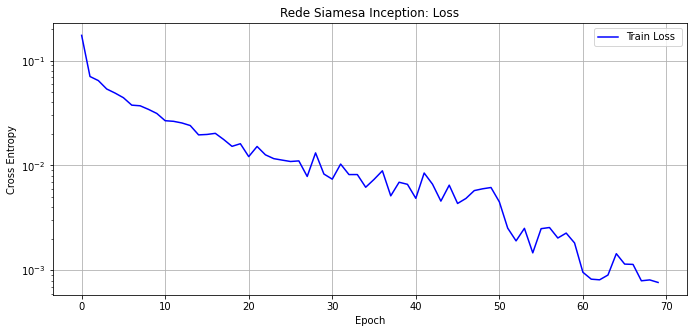

In [ ]:
def diferenca(historico):
  accuracy = historico.history['loss'] 
  val_accuracy = historico.history['val_loss']
  vetor_diferenca = []
  for i in range(len(accuracy)):
    diferenca = abs(accuracy[i] - val_accuracy[i])
    vetor_diferenca.append(diferenca)

  return vetor_diferenca

  
def grafico(historico, nome): 

  plt.subplots(figsize=(25, 5)) 
  # Grafico 1: Loss
  plt.subplot(1,2,1)
  plt.title( nome + ': Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.grid()
  plt.yscale("log")
  plt.plot(historico.history['loss'], label='Train Loss ', color = 'blue')
  #plt.plot(historico.history['val_loss'], label='Val Loss ', color = 'red')
  plt.legend()


  # Grafico 3: Diferença de Loss
  #vetor_diferenca = diferenca(historico)

  #plt.subplot(1,2,2)
  #plt.title(nome + ": Variação do Loss")
  #plt.xlabel("Epocas")
  #plt.ylabel("Diferença")
  ##plt.grid()
  #plt.yscale("log")
  #plt.plot(vetor_diferenca, color = 'red', label = 'Variação do Loss')
  #plt.legend()

  nome_save = os.path.join("/content", nome + ".jpg")
  plt.savefig(nome_save, dpi=400,  transparent=False)
  plt.show()

grafico(historico, "Rede Siamesa Inception")

# Teste

## Funções

In [ ]:
_ , (x_test_origin, y_test_origin) = keras.datasets.mnist.load_data()
del _

In [ ]:
def visualize(x_test_origin):
    """Visualize a few triplets from the supplied batches."""
    print("Total de imagens: {0}  Resolução: {1}x{2}".format(x_test_origin.shape[0], x_test_origin.shape[1], x_test_origin.shape[2]))
    def show(ax, image):
        ax.imshow(image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], x_test_origin[random.randint(0, 1000)])
        show(axs[i, 1], x_test_origin[random.randint(0, 1000)])
        show(axs[i, 2], x_test_origin[random.randint(0, 1000)])

In [ ]:
nome = ["zero", "um", "dois", "tres", "quatro", "cinco", "seis", "sete", "oito", "nove"]

def prepare_database(model):
  database = {}
  x_test_origin, y_test_origin
  for i in range(10):
    indice = 0
    while True:
      if y_test_origin[indice] == i:
        identity =  nome[i]     
        database[identity] = img_to_encoding(x_test_origin[indice], model)
        break
      else:
        indice += 1

  return database

In [ ]:
def img_to_encoding(image, model):
  img_resized = cv2.resize(image, (size, size))
  img_resized = tf.cast(img_resized, tf.float32)/ 255
  img = np.array([img_resized]) 
  img = img.reshape(img.shape[0], 1, size, size)

  embedding = model.predict(img, verbose=0)
  
  return embedding

In [ ]:
def recognise_class(image, database, model):
    encoding = img_to_encoding(image, model)
    identity = None
    min_dist = 100
    for (name, db_enc) in database.items():
        
        dist = np.linalg.norm(db_enc - encoding)
        #print('distance for %s is %s' %(name, dist))
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.6:
        return "can't recognise."
    else:
        return str(identity)

def recognise_class_2(image, database, model):
    encoding = img_to_encoding(image, model)
    identity = None
    min_dist = 100
    for (name, db_enc) in database.items():
        
        dist = np.linalg.norm(db_enc - encoding)
        print('distance for %s is %s' %(name, dist))
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.6:
        return "can't recognise."
    else:
        return str(identity)

In [ ]:
def metricas(saida):
  certo = 0
  errado = 0
  incerto = 0
  
  for resposta in saida:
    if resposta[1] == nome[resposta[0]]:
      certo += 1
    else:
      if resposta[1] == "can't recognise.":
        incerto += 1
      else:
        if resposta[1] != nome[resposta[0]]:
          errado += 1
  print()
  print("Total de imagem: {0}    Certas: {1}   Erradas: {2}   Incertas: {3}".format(len(saida), certo, errado, incerto))

## Testes

Total de imagens: 10000  Resolução: 28x28


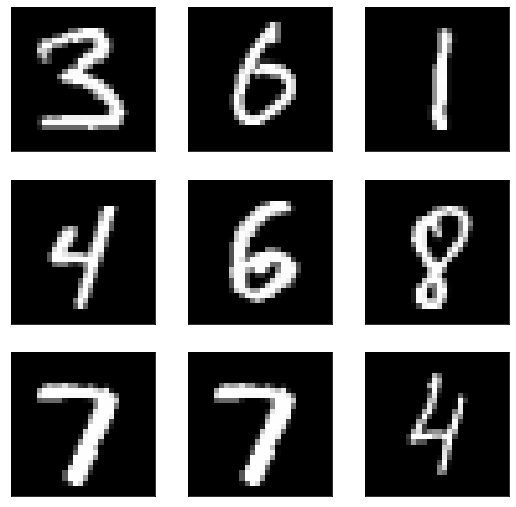

In [ ]:
# Permite visualizar algumas imagens do conjunto de teste
visualize(x_test_origin)

Para classificar um imagem como pertencente a uma das classe, o processo é dividido em 4 fasses: \

1 - uma imagem representando cada classe é codificada. \

2 - a imagem que sera classifica é codificada. \

3 - verifica a distancia da imagem codificada na fasse 2 com cada uma das imagens codificadas na fasse 1. \

4 - a imagem sera classificada de acordo com a menor distancia encontrada na fasse 3.


In [ ]:
embedding_model = tf.keras.models.load_model("/content/drive/MyDrive/Codedepot/face_recognition/Treino_Mnint/embedding_model.h5")

In [ ]:
database = prepare_database(modelo)
saida = []

for i in tqdm (range(10000), desc="Testando..."):
  classe = recognise_class(x_test_origin[i], database, modelo)
  #print("id {2}:: Classe Real: {0} >> Classe Prevista: {1}".format(y_test_origin[i], classe, i))
  saida.append([y_test_origin[i], classe])

metricas(saida) 

Testando...: 100%|██████████| 10000/10000 [09:59<00:00, 16.68it/s]


Total de imagem: 10000    Certas: 9963   Erradas: 29   Incertas: 8


In [ ]:
database = prepare_database(modelo)
classe = recognise_class_2(x_test_origin[417], database, modelo)
print()
print("Classe Real: {0} >> Classe Prevista: {1}".format(y_test_origin[417], classe))

distance for zero is 1.5048177
distance for um is 1.5384765
distance for dois is 1.6921117
distance for tres is 1.4914639
distance for quatro is 1.4663353
distance for cinco is 1.4988364
distance for seis is 1.4920801
distance for sete is 1.5077233
distance for oito is 1.6184503
distance for nove is 0.04209562

Classe Real: 9 >> Classe Prevista: nove
